# Final Project Data Wrangling

## A. Pendahuluan
- **Deskripsi dataset**: 'NFL Stadium Attendance', sebuah pak dataset(terdiri dari tiga sub dataset) yang mencatat *Pro Football Reference team standings*. Ada **tiga** buah sub dataset, yaitu:
    1. `attendance.csv` yang berisi kehadiran tim secara mingguan,
    2. `standings.csv` yang berisi hasil komputasi pertandingan tim, dan
    3. `games.csv` yang berisi data pertandingan antara tim yang mentah.

    Ketiga dataset tersebut bisa digabungkan melalui kolom `year`, `team_name`, dan `team`.
- **Alasan dataset menarik**: Seperti yang telah kami sebutkan, dataset ini memiliki **tiga sub dataset** yang di mana bisa **digabungkan** serta kategori **dataset** seperti ini belum pernah kami olah sebelumnya. Dan juga untuk `standings.csv` adalah dataset yang berisi hasil komputasi, yang biasanya dataset umumnya benar-benar murni/mentah namun kami disajikan dengan **dua sub dataset mentah** dan **satu sub dataset yang diolah**.

- **Pertanyaan/tujuan analisis**: -

## B. Setup \& Package
### 1. Import library & penyesuaian lingkungan notebook
Pada sel berikut kami impor library yang akan digunakan dan melakukan penyesuaian terhadap notebook kami.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

### 2. Penyimpanan path file
Setelah mengimpor library, kami melakukan setup *path* untuk membaca serta menulis dataset.

In [49]:
raw_path = {
    'attendance': '../data/raw/attendance.csv',
    'games': '../data/raw/games.csv',
    'standings': '../data/raw/standings.csv'
}

processed_path = '../data/processed/nfl.csv'


### 3. Penjelasan fungsi paket
- `pandas (pd)`: -
- `numpy (np)`: -
- `matplotlib.pyplot (plt)`: -
- `seaborn (sns)`: -

## C. Data Preparation

### 1. Baca dataset dari data yang ada sesuai *path*

In [50]:
attendance = pd.read_csv(raw_path['attendance'])
games = pd.read_csv(raw_path['games'])
standings = pd.read_csv(raw_path['standings'])

### 2. Proses *Cleaning* dan *Data Wrangling*
- Pembuatan function untuk melakukan *checking* pada dataset:

In [51]:
def cek_data(df):
    print("\nDimensi:",df.shape)
    print("\nTipe Data:\n",df.dtypes)
    print("\nMissing Values:\n",df.isnull().sum())
    print("\nDuplicates:",df.duplicated().sum())

- Pengecekan awal untuk dataset `games`:

In [52]:
print("==== Tahap Pengecekan Awal untuk Data games ====")
cek_data(games)
print("=" * 40, "\n")

==== Tahap Pengecekan Awal untuk Data games ====

Dimensi: (5324, 19)

Tipe Data:
 year               int64
week              object
home_team         object
away_team         object
winner            object
tie               object
day               object
date              object
time              object
pts_win            int64
pts_loss           int64
yds_win            int64
turnovers_win      int64
yds_loss           int64
turnovers_loss     int64
home_team_name    object
home_team_city    object
away_team_name    object
away_team_city    object
dtype: object

Missing Values:
 year                 0
week                 0
home_team            0
away_team            0
winner               0
tie               5314
day                  0
date                 0
time                 0
pts_win              0
pts_loss             0
yds_win              0
turnovers_win        0
yds_loss             0
turnovers_loss       0
home_team_name       0
home_team_city       0
away_team_name     

- Identifikasi setelah pengecekan `games`:
    - Kolom `date` bertipe data `object`, harus diganti menjadi `date` untuk analisis deret waktu yang baik.
    - Kolom `week` bertipe data `object` karena di baris bawah ada data yang berupa istilah. Daripada memformat kolom, kami tambahkan kolom baru yaitu `week_num`.
    - Kolom `tie` banyak missing value, harus diganti dengan `0` untuk menandakan tidak adanya kejadian seri/*tie*.
    - Kolom `time` bertipe data `object`. Akan kami biarkan karena `time` sendiri ambigu karena ada banyak `date`. Kami akan buat kolom baru untuk analisis bernama `kickoff_time`.

- Prosedur penanganan untuk `games`:

In [53]:
games = pd.read_csv(raw_path['games']) # load dataset lagi untuk mencegah error

# Buat kolom dummy untuk ubah tipe data kolom date
games['full_date_str'] = games['date'].astype(str) + ', ' + games['year'].astype(str)

# Ubah tipe data ke datetime
games['date'] = pd.to_datetime(games['full_date_str'])

# Membuat kolom kickoff_time
games['kickoff_time'] = pd.to_datetime(
    games['date'].astype(str) + ' ' + games['time'],
    format='%Y-%m-%d %I:%M%p',
    errors = 'coerce'
)

# Pemetaan kolom week object ke integer
week_map = {
    'WildCard':18,
    'Division':19,
    'ConfChamp':20,
    'SuperBowl':21
}

# Membuat kolom week_num
games['week_num'] = games['week'].replace(week_map).astype(int)

# Mengisi kolom tie yang kosong dengan 0
games['tie'] = games['tie'].fillna(0)

# Cek akhir
print("==== Cek Akhir untuk Data games ====")
cek_data(games)
print("=" * 40, "\n")

==== Cek Akhir untuk Data games ====

Dimensi: (5324, 22)

Tipe Data:
 year                       int64
week                      object
home_team                 object
away_team                 object
winner                    object
tie                       object
day                       object
date              datetime64[ns]
time                      object
pts_win                    int64
pts_loss                   int64
yds_win                    int64
turnovers_win              int64
yds_loss                   int64
turnovers_loss             int64
home_team_name            object
home_team_city            object
away_team_name            object
away_team_city            object
full_date_str             object
kickoff_time      datetime64[ns]
week_num                   int64
dtype: object

Missing Values:
 year              0
week              0
home_team         0
away_team         0
winner            0
tie               0
day               0
date              0
time       

In [54]:
print("Data games setelah dibersihkan:")
games

Data games setelah dibersihkan:


,year,week,home_team,away_team,winner,tie,day,date,time,pts_win,pts_loss,yds_win,turnovers_win,yds_loss,turnovers_loss,home_team_name,home_team_city,away_team_name,away_team_city,full_date_str,kickoff_time,week_num
0,2000,1,Minnesota Vikings,Chicago Bears,Minnesota Vikings,0,Sun,2000-09-03,1:00PM,30,27,374,1,425,1,Vikings,Minnesota,Bears,Chicago,"September 3, 2000",2000-09-03 13:00:00,1
1,2000,1,Kansas City Chiefs,Indianapolis Colts,Indianapolis Colts,0,Sun,2000-09-03,1:00PM,27,14,386,2,280,1,Chiefs,Kansas City,Colts,Indianapolis,"September 3, 2000",2000-09-03 13:00:00,1
2,2000,1,Washington Redskins,Carolina Panthers,Washington Redskins,0,Sun,2000-09-03,1:01PM,20,17,396,0,236,1,Redskins,Washington,Panthers,Carolina,"September 3, 2000",2000-09-03 13:01:00,1
3,2000,1,Atlanta Falcons,San Francisco 49ers,Atlanta Falcons,0,Sun,2000-09-03,1:02PM,36,28,359,1,339,1,Falcons,Atlanta,49ers,San Francisco,"September 3, 2000",2000-09-03 13:02:00,1
4,2000,1,Pittsburgh Steelers,Baltimore Ravens,Baltimore Ravens,0,Sun,2000-09-03,1:02PM,16,0,336,0,223,1,Steelers,Pittsburgh,Ravens,Baltimore,"September 3, 2000",2000-09-03 13:02:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2019,Division,Kansas City Chiefs,Houston Texans,Kansas City Chiefs,0,Sun,2019-01-12,3:05PM,51,31,434,1,442,1,Chiefs,Kansas City,Texans,Houston,"January 12, 2019",2019-01-12 15:05:00,19
5320,2019,Division,Green Bay Packers,Seattle Seahawks,Green Bay Packers,0,Sun,2019-01-12,6:40PM,28,23,344,0,375,0,Packers,Green Bay,Seahawks,Seattle,"January 12, 2019",2019-01-12 18:40:00,19
5321,2019,ConfChamp,Kansas City Chiefs,Tennessee Titans,Kansas City Chiefs,0,Sun,2019-01-19,3:05PM,35,24,404,0,295,0,Chiefs,Kansas City,Titans,Tennessee,"January 19, 2019",2019-01-19 15:05:00,20
5322,2019,ConfChamp,San Francisco 49ers,Green Bay Packers,San Francisco 49ers,0,Sun,2019-01-19,6:40PM,37,20,354,0,358,3,49ers,San Francisco,Packers,Green Bay,"January 19, 2019",2019-01-19 18:40:00,20


- Pengecekan awal untuk dataset `attendance`:

In [55]:
print("==== Tahap Pengecekan Awal untuk Data attendance ====")
cek_data(attendance)
print("=" * 40, "\n")

==== Tahap Pengecekan Awal untuk Data attendance ====

Dimensi: (10846, 8)

Tipe Data:
 team                  object
team_name             object
year                   int64
total                  int64
home                   int64
away                   int64
week                   int64
weekly_attendance    float64
dtype: object

Missing Values:
 team                   0
team_name              0
year                   0
total                  0
home                   0
away                   0
week                   0
weekly_attendance    638
dtype: int64

Duplicates: 0



- Identifikasi setelah pengecekan `attendance`:
    - Kolom `weekly_attendance` ada 638 missing values, harus di*drop* karena tidak ada permainan yang berlangsung pada waktu itu.
    - Kolom yang sama bertipe data `float64`, harus dikonversi ke `int64` karena jumlah *attendance* tidak mungkin desimal.

- Prosedur penanganan untuk `attendance`:

In [56]:
# Drop missing value
attendance.dropna(subset=['weekly_attendance'], inplace=True)

# Memperbaiki tipe data
attendance['weekly_attendance'] = attendance['weekly_attendance'].astype(int)

# Cek akhir
print("==== Cek Akhir untuk Data attendance ====")
cek_data(attendance)
print("=" * 40, "\n")

==== Cek Akhir untuk Data attendance ====

Dimensi: (10208, 8)

Tipe Data:
 team                 object
team_name            object
year                  int64
total                 int64
home                  int64
away                  int64
week                  int64
weekly_attendance     int64
dtype: object

Missing Values:
 team                 0
team_name            0
year                 0
total                0
home                 0
away                 0
week                 0
weekly_attendance    0
dtype: int64

Duplicates: 0



In [57]:
print("Data attendance setelah dibersihkan:")
attendance

Data attendance setelah dibersihkan:


,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985
5,Arizona,Cardinals,2000,893926,387475,506451,6,44296
...,...,...,...,...,...,...,...,...
10841,Washington,Redskins,2019,1101466,523906,577560,13,71504
10842,Washington,Redskins,2019,1101466,523906,577560,14,77296
10843,Washington,Redskins,2019,1101466,523906,577560,15,63246
10844,Washington,Redskins,2019,1101466,523906,577560,16,66083


- Pengecekan awal untuk dataset `standings`:

In [58]:
print("==== Tahap Pengecekan Awal untuk Data standings ====")
cek_data(standings)
print("=" * 40)

==== Tahap Pengecekan Awal untuk Data standings ====

Dimensi: (638, 15)

Tipe Data:
 team                     object
team_name                object
year                      int64
wins                      int64
loss                      int64
points_for                int64
points_against            int64
points_differential       int64
margin_of_victory       float64
strength_of_schedule    float64
simple_rating           float64
offensive_ranking       float64
defensive_ranking       float64
playoffs                 object
sb_winner                object
dtype: object

Missing Values:
 team                    0
team_name               0
year                    0
wins                    0
loss                    0
points_for              0
points_against          0
points_differential     0
margin_of_victory       0
strength_of_schedule    0
simple_rating           0
offensive_ranking       0
defensive_ranking       0
playoffs                0
sb_winner               0
dtype: int64

- Identifikasi setelah pengecekan `standings`:
    -  Tidak ada kejanggalan yang ditemukan sejauh ini tapi kami akan melakukan koreksi nama kolom untuk penggabungan dataset.

- Prosedur penanganan untuk `standings`:

In [72]:
standing = standings.rename(
    columns={
        'wins': 'seasons_wins',
        'loss': 'season_losses',
        'simple_rating': 'season_rating',
        'offensive_rating': 'off-rank',
        'defensive_ranking': 'def_rank',
        'sb_winner': 'superbowl_winner'
    }
)

### 3. Identifikasi yang lain (*outlier checking*)
- Pengecekan dilakukan pada data `attendance` dan `games` karena keduanya adalah data mentah/murni.


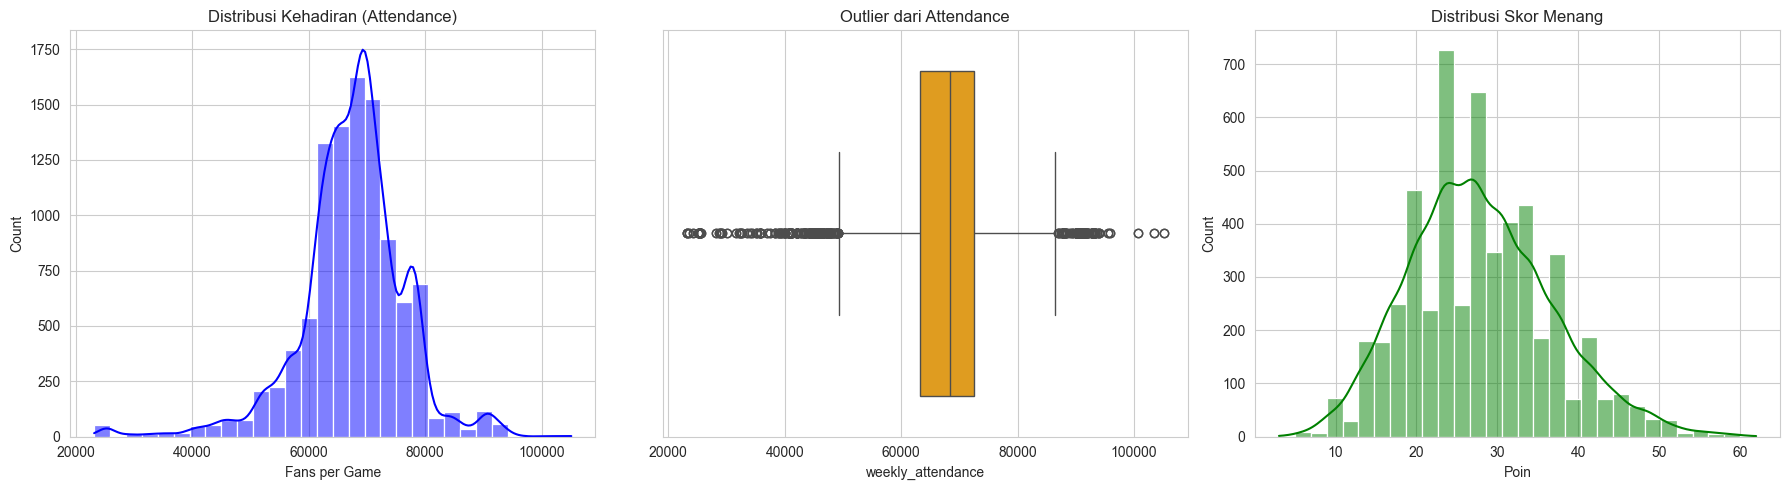

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(attendance['weekly_attendance'],
             bins = 30,
             kde = True,
             ax = axes[0],
             color = 'blue')
axes[0].set_title('Distribusi Kehadiran (Attendance)')
axes[0].set_xlabel('Fans per Game')

sns.boxplot(x = attendance['weekly_attendance'],
            ax = axes[1],
            color = 'orange')
axes[1].set_title('Outlier dari Attendance')

sns.histplot(games['pts_win'],
             bins = 30,
             kde = True,
             ax = axes[2],
             color = 'green')
axes[2].set_title('Distribusi Skor Menang')
axes[2].set_xlabel('Poin')

plt.tight_layout()
plt.show()

Tidak ada outlier ekstrem yang terdeteksi dari kedua dataset tersebut untuk kolom yang telah dicek.

### 4. Identifikasi data `standings` tambahan

Karena `standings` adalah dataset yang asalnya dari komputasi, harusnya tidak ada kesalahan. Namun kami coba cek sesuai logika pertandingan, antara lain:
1. Pertandingan *Wins* + *Loses* = *Games* dimainkan? Harusnya ada baris dengan value 16 (15 atau 17 untuk tahun tertentu) saja.
2. Apakah Poin *For* - Poin *Against* sama dengan Poin *Differential*?
3. Ada eror selain *non-zero*?

In [61]:
# Pertandingan Wins + Loses
standings['games_played'] = standings['wins'] + standings['loss']
print('Perhitungan pertandingan Win-Lose\n',
      standings['games_played'].value_counts())

# Poin Differential
standings['calc_diff'] = standings['points_for'] - standings['points_against']
standings['math_error'] = standings['points_differential'] - standings['calc_diff']

# Eror Non-zero
errors = standings[standings['math_error']!=0]
print('\nBaris dengan kesalahan perhitungan:', len(errors))

Perhitungan pertandingan Win-Lose
 games_played
16    618
15     20
Name: count, dtype: int64

Baris dengan kesalahan perhitungan: 0


### 5. Penggabungan ketiga sub dataset

In [62]:
# Penggabungan games dan attendance
base_df = pd.merge(
    games,
    attendance,
    left_on = ['home_team_name', 'year', 'week_num'],
    right_on = ['team_name', 'year', 'week'],
    how = 'inner'
)

# Penggabungan base dan standings
nfl = pd.merge(
    base_df,
    standings,
    left_on = ['home_team_name', 'year'],
    right_on = ['team_name', 'year'],
    how = 'left',
    suffixes = ('', '_standings_dup') # mengatasi nama duplikat
)

# Pembersihan pasca penggabungan data
cols_to_drop = ['team_name', 'week_y', 'week_x']
nfl.drop(columns = cols_to_drop, inplace = True, errors = 'ignore')

# Penamaan baru untuk kolom weekly attendance
nfl.rename(columns = {'weekly_attendance': 'attendance'},
                 inplace = True)

# Membuat kolom untuk menghitung poin home team kalah/menang
def get_home_diff(row):
    if row['home_team'] == row['winner']:
        return row['pts_win'] - row['pts_loss']
    else:
        return row['pts_loss'] - row['pts_win']
    
# Drop kolom yang tidak dipakai
cols_to_remove = [
    'calc_diff', 'math_error', 'games_played', 
    'full_date_str', 'team_standings_dup', 'team_name_standings_dup', 'team'
]

nfl.drop(columns=cols_to_remove, inplace = True, errors = 'ignore')
    
nfl['home_score_diff'] = nfl.apply(get_home_diff, axis = 1)

### 6. Menyimpan data yang telah digabung

In [74]:
print("==== Pengecekan akhir dataset final ====")
cek_data(nfl)
print("=" * 40)

nfl.to_csv(processed_path, index = False)

==== Pengecekan akhir dataset final ====

Dimensi: (5104, 38)

Tipe Data:
 year                             int64
home_team                       object
away_team                       object
winner                          object
tie                             object
day                             object
date                    datetime64[ns]
time                            object
pts_win                          int64
pts_loss                         int64
yds_win                          int64
turnovers_win                    int64
yds_loss                         int64
turnovers_loss                   int64
home_team_name                  object
home_team_city                  object
away_team_name                  object
away_team_city                  object
kickoff_time            datetime64[ns]
week_num                         int64
total                            int64
home                             int64
away                             int64
attendance                  

## D. Exploratory Data Analysis

In [64]:
print('=== Rangkuman Utama ===')
rangkuman = nfl[['attendance', 'home_score_diff', 'pts_win', 'total']].describe()
display(rangkuman)

print('=== Top 5 Tim berdasarkan total kehadiran ===')
top_teams = nfl.groupby('home_team_name')['attendance'].sum().sort_values(ascending=False).head(10)
display(top_teams.to_frame())

=== Rangkuman Utama ===


,attendance,home_score_diff,pts_win,total
count,5104.000000,5104.000000,5104.000000,5.104000e+03
mean,67556.876567,2.356387,27.737461,1.080910e+06
std,9022.457310,14.754366,8.843116,7.288075e+04
min,23127.000000,-49.000000,3.000000,7.606440e+05
25%,63245.500000,-7.000000,21.000000,1.040509e+06
50%,68334.000000,3.000000,27.000000,1.081090e+06
75%,72544.750000,11.000000,34.000000,1.123230e+06
max,105121.000000,59.000000,62.000000,1.322087e+06


=== Top 5 Tim berdasarkan total kehadiran ===


,attendance
home_team_name,
Redskins,12781480
Giants,12566004
Jets,12482825
Cowboys,12469317
Broncos,12159820
Chiefs,11964694
Panthers,11700610
Packers,11485352
Ravens,11291595


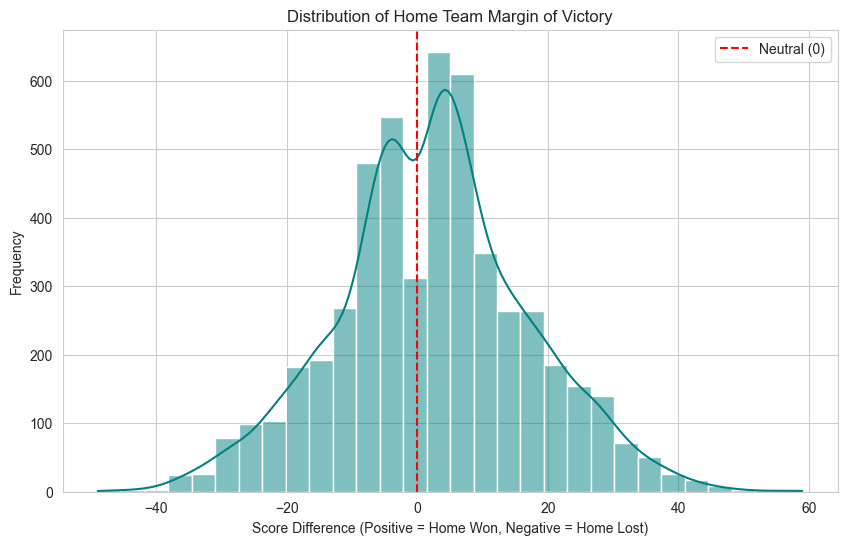

In [65]:
plt.figure(figsize=(10,6))
sns.histplot(nfl['home_score_diff'],
             bins = 30,
             kde = True,
             color = 'teal')

plt.axvline(x=0, color='red', linestyle='--', label='Neutral (0)')

plt.title('Distribution of Home Team Margin of Victory')
plt.xlabel('Score Difference (Positive = Home Won, Negative = Home Lost)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

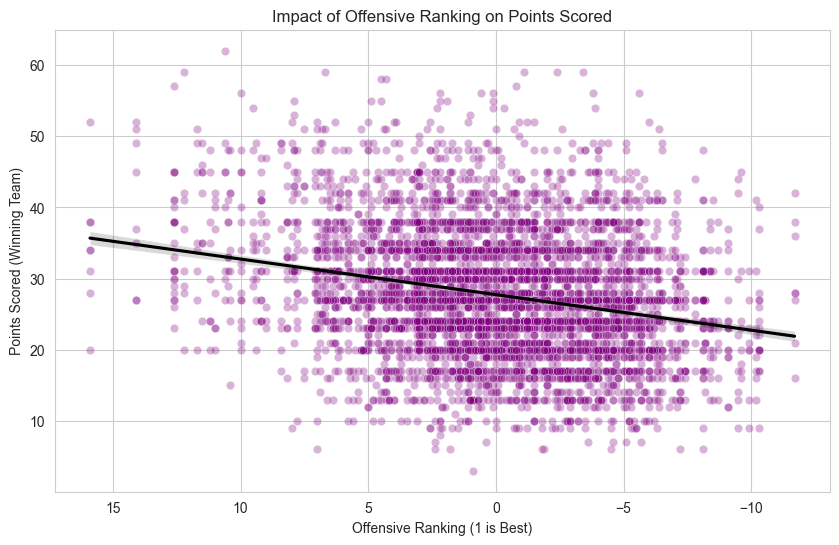

In [66]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=nfl, x='offensive_ranking', y='pts_win', alpha=0.3, color='purple')

sns.regplot(data=nfl, x='offensive_ranking', y='pts_win', scatter=False, color='black')

plt.title('Impact of Offensive Ranking on Points Scored')
plt.xlabel('Offensive Ranking (1 is Best)')
plt.ylabel('Points Scored (Winning Team)')
plt.gca().invert_xaxis()
plt.show()

C:\Users\axioo\AppData\Local\Temp\ipykernel_25276\2656936647.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=nfl, x='week_num', y='attendance', palette='coolwarm')


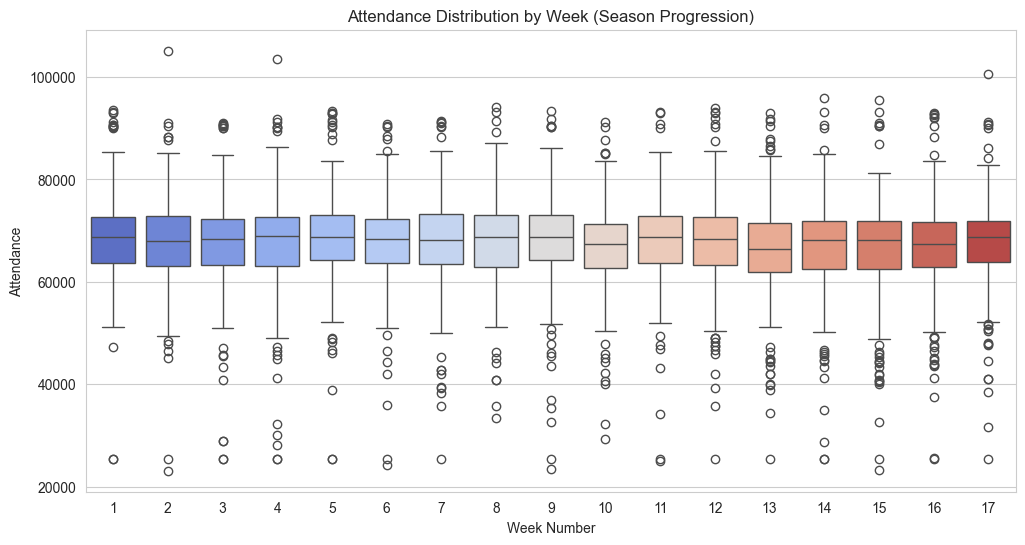

In [67]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=nfl, x='week_num', y='attendance', palette='coolwarm')

plt.title('Attendance Distribution by Week (Season Progression)')
plt.xlabel('Week Number')
plt.ylabel('Attendance')
plt.show()

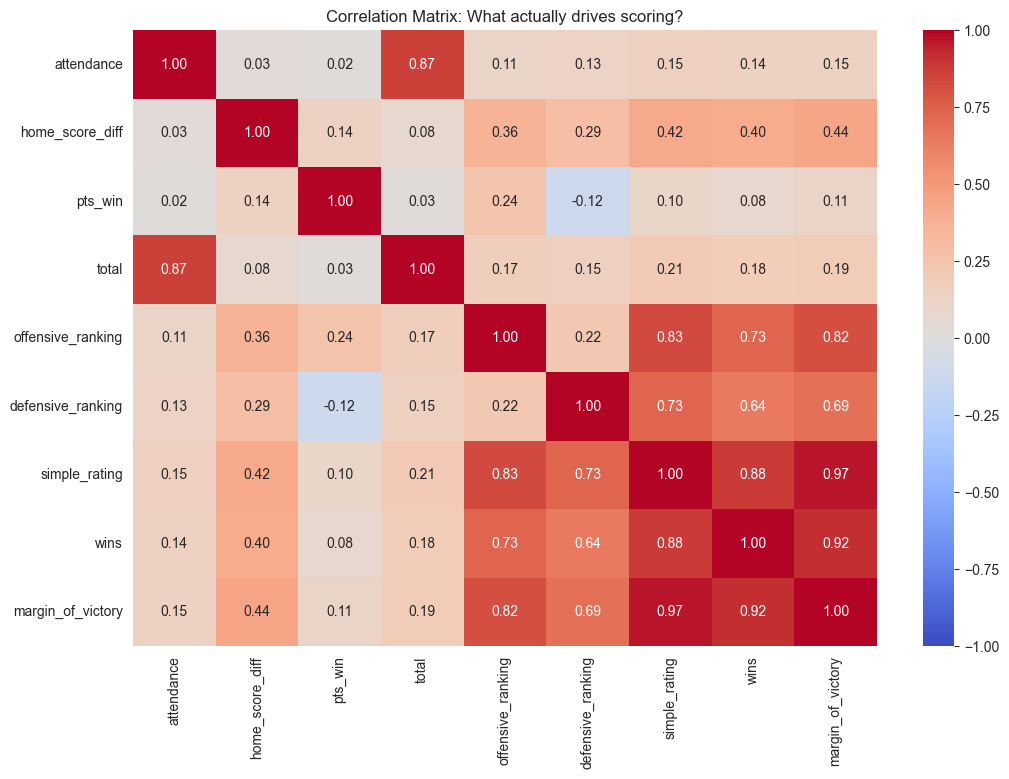

In [68]:
cols_of_interest = [
    'attendance', 'home_score_diff', 'pts_win', 'total', 
    'offensive_ranking', 'defensive_ranking', 'simple_rating', 
    'wins', 'margin_of_victory'
]

corr_matrix = nfl[cols_of_interest].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: What actually drives scoring?')
plt.show()

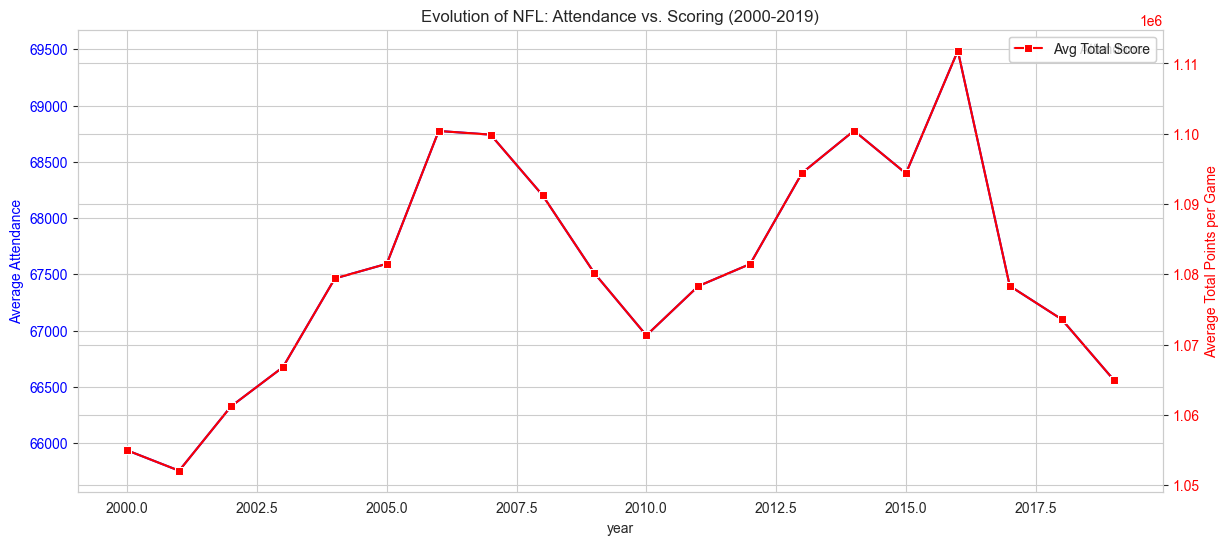

In [69]:
yearly_trends = nfl.groupby('year')[['attendance', 'total']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Attendance on Left Y-Axis
sns.lineplot(data=yearly_trends, x='year', y='attendance', ax=ax1, color='blue', marker='o', label='Avg Attendance')
ax1.set_ylabel('Average Attendance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create Right Y-Axis for Scoring
ax2 = ax1.twinx()
sns.lineplot(data=yearly_trends, x='year', y='total', ax=ax2, color='red', marker='s', label='Avg Total Score')
ax2.set_ylabel('Average Total Points per Game', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Evolution of NFL: Attendance vs. Scoring (2000-2019)')
plt.show()

C:\Users\axioo\AppData\Local\Temp\ipykernel_25276\2004057256.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='team_tier', y='attendance', data=nfl, palette='Set2')


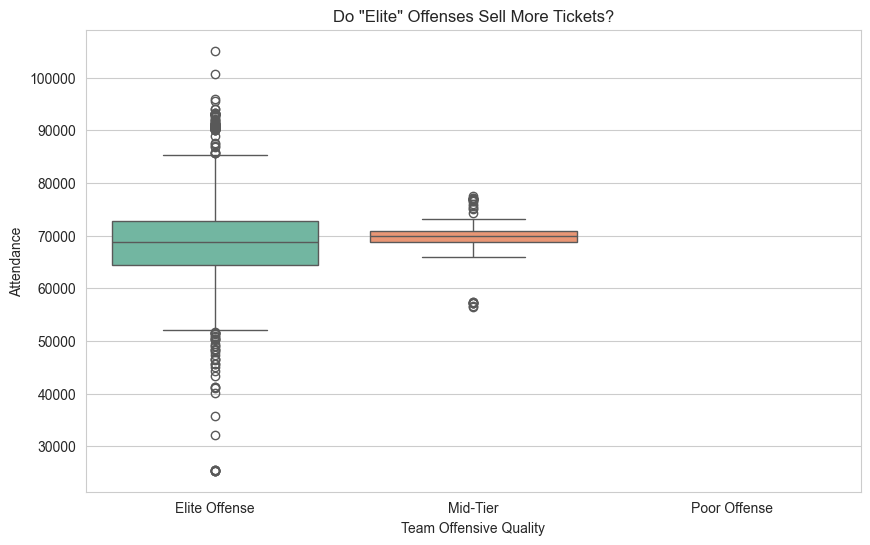

In [70]:
# --- ANALYTICS 3: IMPACT OF TEAM QUALITY ON CROWDS ---

# Discretize Offensive Rank into 3 Bins (Elite, Mid, Poor)
# Rank 1-10 = Elite, 11-22 = Mid, 23-32 = Poor
nfl['team_tier'] = pd.cut(
    nfl['offensive_ranking'], 
    bins=[0, 10, 22, 33], 
    labels=['Elite Offense', 'Mid-Tier', 'Poor Offense']
)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='team_tier', y='attendance', data=nfl, palette='Set2')
plt.title('Do "Elite" Offenses Sell More Tickets?')
plt.xlabel('Team Offensive Quality')
plt.ylabel('Attendance')
plt.show()

C:\Users\axioo\AppData\Local\Temp\ipykernel_25276\1598539642.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_attendance, x='attendance', y='home_team_name', palette='viridis')


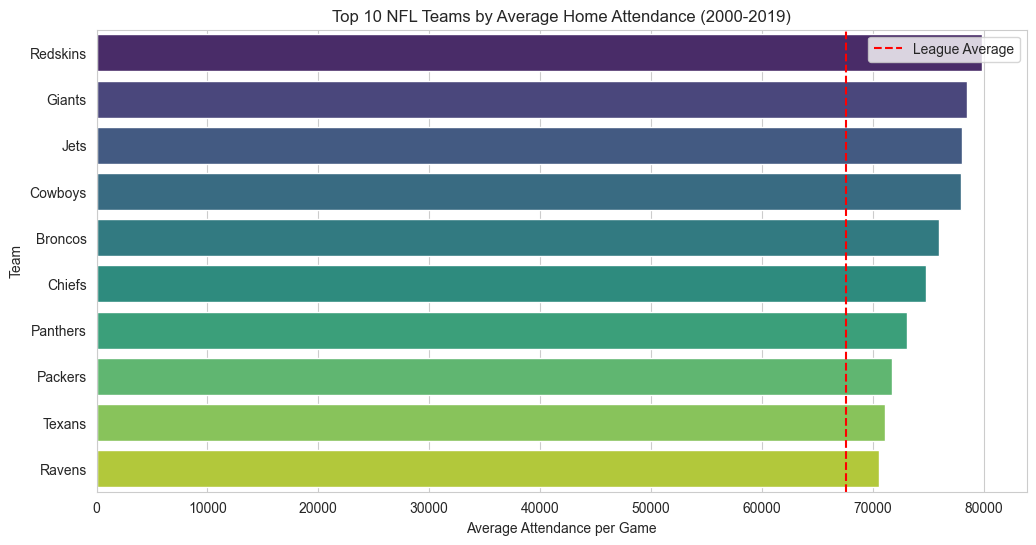

In [71]:
top_attendance = nfl.groupby('home_team_name')['attendance'].mean().sort_values(ascending=False).head(10).reset_index()

# 2. Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_attendance, x='attendance', y='home_team_name', palette='viridis')

plt.title('Top 10 NFL Teams by Average Home Attendance (2000-2019)')
plt.xlabel('Average Attendance per Game')
plt.ylabel('Team')
plt.axvline(x=nfl['attendance'].mean(), color='red', linestyle='--', label='League Average')
plt.legend()
plt.show()

## E. Kesimpulan
### Temuan Utama:
- 
- 
- 

### Keterbatasan:
- 
- 
- 

### Saran Pengembangan:
- 
- 
- 